## Part V - Feature Engineering and Feature Store

University of San Diego - MS Applied AI

AAI-540 Team 5

October 21, 2024

### Setup

In [46]:
# setup environment
%run 0-Environment_Setup.ipynb

Stored 's3_datalake_path_csv' (str)
Stored 'local_data_path_csv' (str)
Stored 's3_datalake_path_parquet' (str)


### Get a rollup of total sales by store, by date

In [47]:
table_name = "cleaned_data"

# Define SQL query
statement = """SELECT 
    date,
    store_nbr,
    round(sum(sales), 2) as sales,
    max(dcoilwtico) as oil,
    max(onpromotion) as onpromotion,
    max(is_holiday) as is_holiday,
    max(city) as city,
    max(state) as state,
    max(cluster) as cluster
    FROM aai540finalprojectdb.cleaned_data
    GROUP BY (date, store_nbr)
ORDER BY date, store_nbr""".format(
    database_name, table_name
)

# get the results
store_sales_df = wr.athena.read_sql_query(statement, database_name)

### Do some further cleanup

- Check for null values
- Impute as necessary

In [49]:
# check nulls in housing_gmaps_data
print(store_sales_df.isnull().sum())

date               0
store_nbr          0
sales              0
oil            25974
onpromotion        0
is_holiday         0
city               0
state              0
cluster            0
dtype: int64


In [50]:
# impute oil values using forward fill
store_sales_df['oil'] = store_sales_df['oil'].fillna(method='ffill')


/tmp/ipykernel_421/2655076859.py:2: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  store_sales_df['oil'] = store_sales_df['oil'].fillna(method='ffill')


In [51]:
# double check all nulls are imputed
store_sales_df[store_sales_df['oil'].isnull()]


,date,store_nbr,sales,oil,onpromotion,is_holiday,city,state,cluster


In [52]:
# break down date into year, month, day, day of week
store_sales_df["date"] = pd.to_datetime(store_sales_df["date"])
store_sales_df["year"] = store_sales_df["date"].dt.year
store_sales_df["month"] = store_sales_df["date"].dt.month
store_sales_df["day"] = store_sales_df["date"].dt.day
store_sales_df["dow"] = store_sales_df["date"].dt.dayofweek

In [53]:
# inspect
store_sales_df

,date,store_nbr,sales,oil,onpromotion,is_holiday,city,state,cluster,year,month,day,dow
0,2013-01-01,1,0.00,93.14,0,1,Quito,Pichincha,13,2013,1,1,1
1,2013-01-01,2,0.00,93.14,0,1,Quito,Pichincha,13,2013,1,1,1
2,2013-01-01,3,0.00,93.14,0,1,Quito,Pichincha,8,2013,1,1,1
3,2013-01-01,4,0.00,93.14,0,1,Quito,Pichincha,9,2013,1,1,1
4,2013-01-01,5,0.00,93.14,0,1,Santo Domingo,Santo Domingo de los Tsachilas,4,2013,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
90931,2017-08-15,50,16879.12,47.57,35,0,Ambato,Tungurahua,14,2017,8,15,1
90932,2017-08-15,51,20154.56,47.57,29,0,Guayaquil,Guayas,17,2017,8,15,1
90933,2017-08-15,52,18600.05,47.57,37,0,Manta,Manabi,11,2017,8,15,1
90934,2017-08-15,53,8208.19,47.57,33,0,Manta,Manabi,13,2017,8,15,1


### Encode Categorical Columns

In [54]:
import math
import seaborn as sns
import matplotlib.pyplot as plt

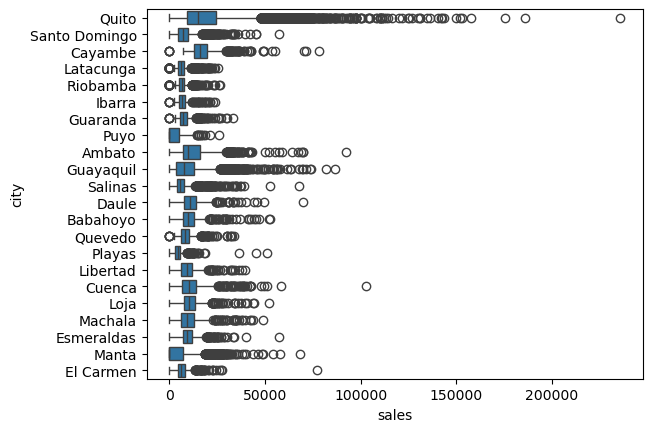

In [55]:
# Plot city vs sales to check for a relationship between the city a store is in and sales
sns.boxplot(data=store_sales_df, y='city', x='sales')
plt.show()

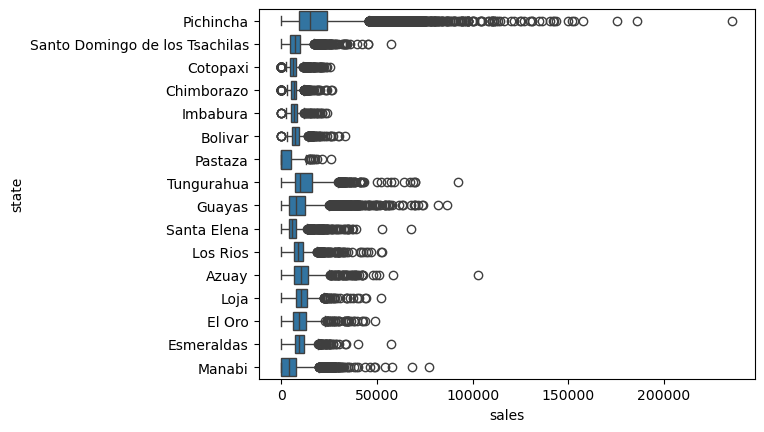

In [56]:
# Plot state vs sales to check for a relationship between the state a store is in and sales
sns.boxplot(data=store_sales_df, y='state', x='sales')
plt.show()

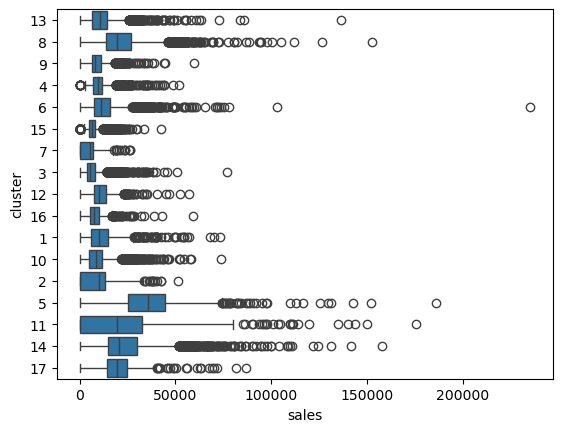

In [57]:
# Plot cluster vs sales to check for a relationship between store cluster and sales
store_sales_df['cluster'] = store_sales_df['cluster'].astype(str)
sns.boxplot(data=store_sales_df, y='cluster', x='sales')
plt.show()

In [58]:
# Derive new variables combining city state and cluster
store_sales_df['city-state'] = store_sales_df['city'] + "-" + store_sales_df['state']
store_sales_df['city-state-cluster'] = store_sales_df['city'] + "-" + store_sales_df['state'] + "-" + store_sales_df['cluster'].astype('str')
store_sales_df.head()

,date,store_nbr,sales,oil,onpromotion,is_holiday,city,state,cluster,year,month,day,dow,city-state,city-state-cluster
0,2013-01-01,1,0.0,93.14,0,1,Quito,Pichincha,13,2013,1,1,1,Quito-Pichincha,Quito-Pichincha-13
1,2013-01-01,2,0.0,93.14,0,1,Quito,Pichincha,13,2013,1,1,1,Quito-Pichincha,Quito-Pichincha-13
2,2013-01-01,3,0.0,93.14,0,1,Quito,Pichincha,8,2013,1,1,1,Quito-Pichincha,Quito-Pichincha-8
3,2013-01-01,4,0.0,93.14,0,1,Quito,Pichincha,9,2013,1,1,1,Quito-Pichincha,Quito-Pichincha-9
4,2013-01-01,5,0.0,93.14,0,1,Santo Domingo,Santo Domingo de los Tsachilas,4,2013,1,1,1,Santo Domingo-Santo Domingo de los Tsachilas,Santo Domingo-Santo Domingo de los Tsachilas-4


In [59]:
print(f"Unique city-state values: {store_sales_df['city-state'].nunique()}")
print(f"Unique city-state-cluster values: {store_sales_df['city-state-cluster'].nunique()}")

Unique city-state values: 22
Unique city-state-cluster values: 41


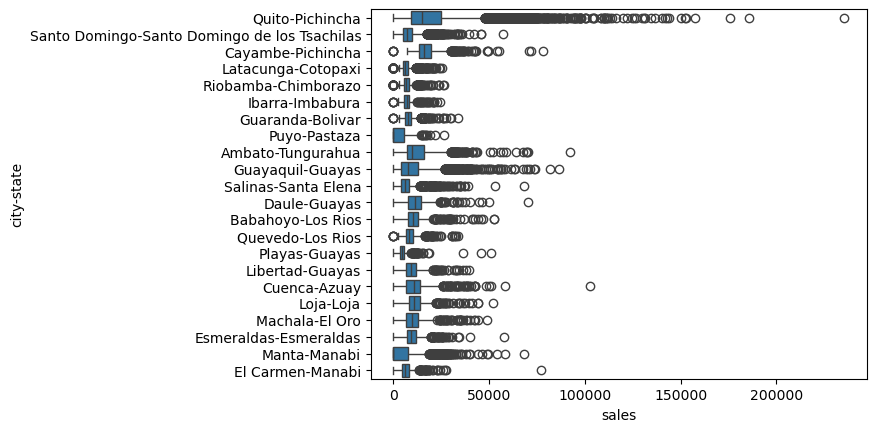

In [60]:
# City-state vs sales
sns.boxplot(data=store_sales_df, y='city-state', x='sales')
plt.show()

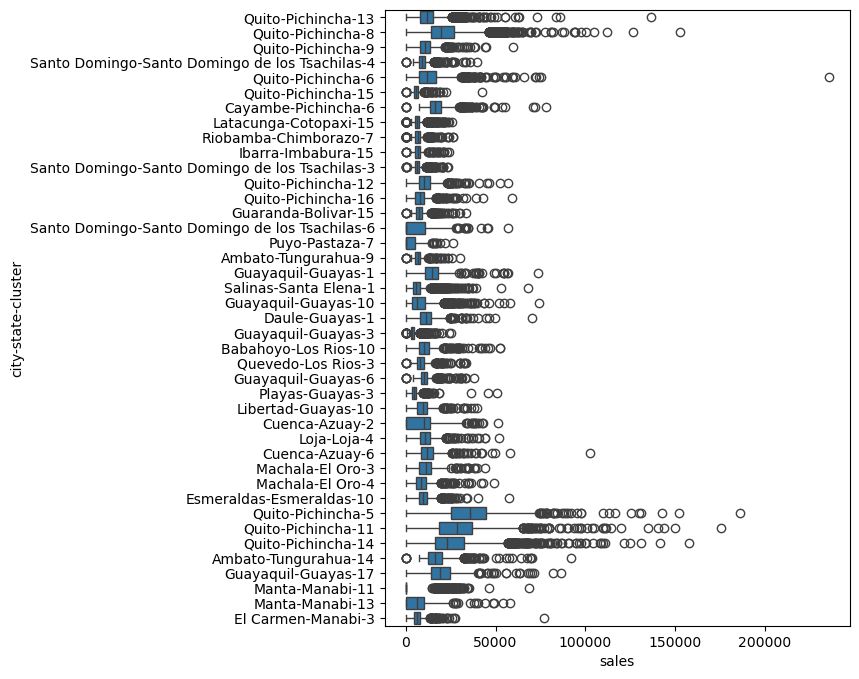

In [61]:
# City-state-cluster vs sales
plt.figure(figsize=(6, 8))
sns.boxplot(data=store_sales_df, y='city-state-cluster', x='sales')
plt.show()

In [62]:
from sklearn.feature_extraction import FeatureHasher

In [63]:
# Apply hash encoding to the non-temporal categorical variables
unique_cats = store_sales_df['city-state-cluster'].nunique()
buckets = 10
print(f"Using {buckets} buckets")

feature_hasher = FeatureHasher(n_features=buckets, input_type="string")
hashed_features = feature_hasher.transform(store_sales_df['city-state-cluster'].apply(lambda x: [x]))

hashed_feature_columns = [f'hash_{i}' for i in range(buckets)]
hashed_features_df = pd.DataFrame(hashed_features.toarray(), columns=hashed_feature_columns)

Using 10 buckets


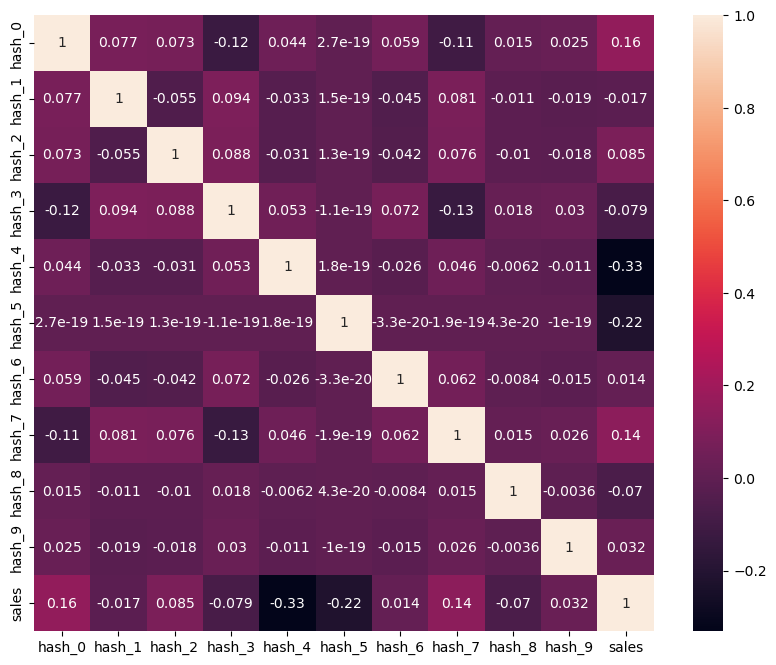

In [64]:
# Use a correlation matrix to try to identify the ideal number of buckets
temp_corr_df = pd.DataFrame(hashed_features.toarray(), columns=hashed_feature_columns)
temp_corr_df['sales'] = store_sales_df['sales']

corr = temp_corr_df.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True)
plt.show()

In [65]:
# Add hashed features to the data
store_sales_df = pd.concat([store_sales_df, hashed_features_df], axis=1)
store_sales_df.head()

,date,store_nbr,sales,oil,onpromotion,is_holiday,city,state,cluster,year,...,hash_0,hash_1,hash_2,hash_3,hash_4,hash_5,hash_6,hash_7,hash_8,hash_9
0,2013-01-01,1,0.0,93.14,0,1,Quito,Pichincha,13,2013,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2013-01-01,2,0.0,93.14,0,1,Quito,Pichincha,13,2013,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2013-01-01,3,0.0,93.14,0,1,Quito,Pichincha,8,2013,...,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0
3,2013-01-01,4,0.0,93.14,0,1,Quito,Pichincha,9,2013,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0
4,2013-01-01,5,0.0,93.14,0,1,Santo Domingo,Santo Domingo de los Tsachilas,4,2013,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [66]:
# use labelencoder to encode categorical columns
from sklearn.preprocessing import LabelEncoder 
le = LabelEncoder()

store_sales_df['city'] = le.fit_transform(store_sales_df['city'])
store_sales_df['state'] = le.fit_transform(store_sales_df['state'])

store_sales_df

,date,store_nbr,sales,oil,onpromotion,is_holiday,city,state,cluster,year,...,hash_0,hash_1,hash_2,hash_3,hash_4,hash_5,hash_6,hash_7,hash_8,hash_9
0,2013-01-01,1,0.00,93.14,0,1,18,12,13,2013,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2013-01-01,2,0.00,93.14,0,1,18,12,13,2013,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2013-01-01,3,0.00,93.14,0,1,18,12,8,2013,...,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0
3,2013-01-01,4,0.00,93.14,0,1,18,12,9,2013,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0
4,2013-01-01,5,0.00,93.14,0,1,21,14,4,2013,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
90931,2017-08-15,50,16879.12,47.57,35,0,0,15,14,2017,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
90932,2017-08-15,51,20154.56,47.57,29,0,8,6,17,2017,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0
90933,2017-08-15,52,18600.05,47.57,37,0,14,10,11,2017,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
90934,2017-08-15,53,8208.19,47.57,33,0,14,10,13,2017,...,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0


In [67]:
# Apply angular distance encoding to temporal variables
store_sales_df['month_cos'] = np.cos(2*np.pi * (store_sales_df['month']/12))
store_sales_df['month_sin'] = np.sin(2*np.pi * (store_sales_df['month']/12))

store_sales_df['day_cos'] = np.cos(2*np.pi * (store_sales_df['day']/31))
store_sales_df['day_sin'] = np.sin(2*np.pi * (store_sales_df['day']/31))

store_sales_df['dow_cos'] = np.cos(2*np.pi * (store_sales_df['dow']/7))
store_sales_df['dow_sin'] = np.sin(2*np.pi * (store_sales_df['dow']/7))


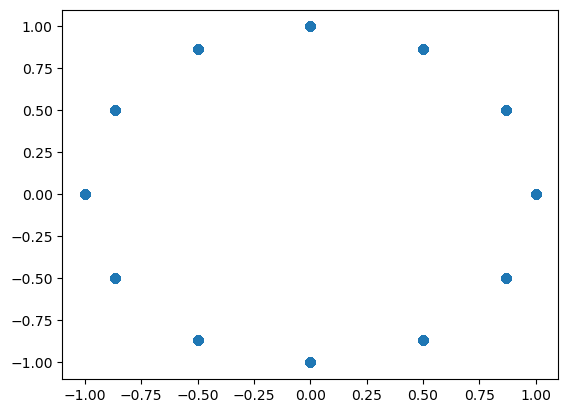

In [68]:
# Plot the encoded month variable
plt.scatter(store_sales_df['month_cos'], store_sales_df['month_sin'])
plt.show()

### Create sales record ID for feature store

In [69]:
# convert date to format compatible with feature store
store_sales_df['date'] = store_sales_df['date'].apply(lambda x: x.strftime('%Y-%m-%d'))

In [70]:
# engineer id feature based on date and store_nbr
store_sales_df['sales_record_id'] = store_sales_df['date'].apply(lambda x: str(x)) + ":" + store_sales_df['store_nbr'].apply(lambda x: str(x))
store_sales_df

,date,store_nbr,sales,oil,onpromotion,is_holiday,city,state,cluster,year,...,hash_7,hash_8,hash_9,month_cos,month_sin,day_cos,day_sin,dow_cos,dow_sin,sales_record_id
0,2013-01-01,1,0.00,93.14,0,1,18,12,13,2013,...,0.0,0.0,0.0,0.866025,0.500000,0.979530,0.201299,0.62349,0.781831,2013-01-01:1
1,2013-01-01,2,0.00,93.14,0,1,18,12,13,2013,...,0.0,0.0,0.0,0.866025,0.500000,0.979530,0.201299,0.62349,0.781831,2013-01-01:2
2,2013-01-01,3,0.00,93.14,0,1,18,12,8,2013,...,0.0,0.0,0.0,0.866025,0.500000,0.979530,0.201299,0.62349,0.781831,2013-01-01:3
3,2013-01-01,4,0.00,93.14,0,1,18,12,9,2013,...,0.0,-1.0,0.0,0.866025,0.500000,0.979530,0.201299,0.62349,0.781831,2013-01-01:4
4,2013-01-01,5,0.00,93.14,0,1,21,14,4,2013,...,1.0,0.0,0.0,0.866025,0.500000,0.979530,0.201299,0.62349,0.781831,2013-01-01:5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
90931,2017-08-15,50,16879.12,47.57,35,0,0,15,14,2017,...,0.0,0.0,0.0,-0.500000,-0.866025,-0.994869,0.101168,0.62349,0.781831,2017-08-15:50
90932,2017-08-15,51,20154.56,47.57,29,0,8,6,17,2017,...,0.0,-1.0,0.0,-0.500000,-0.866025,-0.994869,0.101168,0.62349,0.781831,2017-08-15:51
90933,2017-08-15,52,18600.05,47.57,37,0,14,10,11,2017,...,0.0,0.0,1.0,-0.500000,-0.866025,-0.994869,0.101168,0.62349,0.781831,2017-08-15:52
90934,2017-08-15,53,8208.19,47.57,33,0,14,10,13,2017,...,0.0,0.0,0.0,-0.500000,-0.866025,-0.994869,0.101168,0.62349,0.781831,2017-08-15:53


In [71]:
# Print data types
store_sales_df.dtypes

date                          object
store_nbr                      Int64
sales                        float64
oil                          float64
onpromotion                    Int64
is_holiday                     Int32
city                           int64
state                          int64
cluster                       object
year                           int32
month                          int32
day                            int32
dow                            int32
city-state            string[python]
city-state-cluster    string[python]
hash_0                       float64
hash_1                       float64
hash_2                       float64
hash_3                       float64
hash_4                       float64
hash_5                       float64
hash_6                       float64
hash_7                       float64
hash_8                       float64
hash_9                       float64
month_cos                    float64
month_sin                    float64
d

### Create Features and Feature Store

In [72]:
# helper function to convert col data types to non-objects
def cast_columns(data_frame):
    for label in data_frame.columns:
        if data_frame.dtypes[label] == "object":
            data_frame[label] = data_frame[label].astype("str").astype("string")
        elif data_frame.dtypes[label] == "bool":
            data_frame[label] = data_frame[label].astype("int")
            
cast_columns(store_sales_df)

In [73]:
# create fime feature
import time

current_time_sec = int(round(time.time()))

# set sales_record_id as primary key
record_identifier_feature_name = 'sales_record_id'
event_time_feature_name = "event_time"

# append EventTime feature
store_sales_df[event_time_feature_name] = pd.Series(
    [current_time_sec] * len(store_sales_df), dtype="float64"
)

In [74]:
from time import gmtime, strftime, sleep
store_sales_feature_group.load_feature_definitions(data_frame=store_sales_df)

[FeatureDefinition(feature_name='date', feature_type=<FeatureTypeEnum.STRING: 'String'>, collection_type=None),
 FeatureDefinition(feature_name='store_nbr', feature_type=<FeatureTypeEnum.INTEGRAL: 'Integral'>, collection_type=None),
 FeatureDefinition(feature_name='sales', feature_type=<FeatureTypeEnum.FRACTIONAL: 'Fractional'>, collection_type=None),
 FeatureDefinition(feature_name='oil', feature_type=<FeatureTypeEnum.FRACTIONAL: 'Fractional'>, collection_type=None),
 FeatureDefinition(feature_name='onpromotion', feature_type=<FeatureTypeEnum.INTEGRAL: 'Integral'>, collection_type=None),
 FeatureDefinition(feature_name='is_holiday', feature_type=<FeatureTypeEnum.INTEGRAL: 'Integral'>, collection_type=None),
 FeatureDefinition(feature_name='city', feature_type=<FeatureTypeEnum.INTEGRAL: 'Integral'>, collection_type=None),
 FeatureDefinition(feature_name='state', feature_type=<FeatureTypeEnum.INTEGRAL: 'Integral'>, collection_type=None),
 FeatureDefinition(feature_name='cluster', featur

In [75]:
# helper function to monitor feature group creation status
def wait_for_feature_group_creation_complete(feature_group):
    status = feature_group.describe().get("FeatureGroupStatus")
    while status == "Creating":
        print("Waiting for Feature Group Creation")
        time.sleep(5)
        status = feature_group.describe().get("FeatureGroupStatus")
    if status != "Created":
        raise RuntimeError(f"Failed to create feature group {feature_group.name}")
    print(f"FeatureGroup {feature_group.name} successfully created.")

In [76]:
# Create Offline Feature Store

# create feature group
store_sales_feature_group.create(
    s3_uri=f"s3://{default_s3_bucket_name}/{prefix}",
    record_identifier_name=record_identifier_feature_name,
    event_time_feature_name=event_time_feature_name,
    role_arn=role,
    enable_online_store=True,
)

wait_for_feature_group_creation_complete(feature_group=store_sales_feature_group)

Waiting for Feature Group Creation
Waiting for Feature Group Creation
Waiting for Feature Group Creation
Waiting for Feature Group Creation
FeatureGroup store-sales-feature-group-offline successfully created.


In [77]:
# ingest sales data
store_sales_feature_group.ingest(data_frame=store_sales_df, max_workers=3, wait=True)


IngestionManagerPandas(feature_group_name='store-sales-feature-group-offline', feature_definitions={'date': {'FeatureName': 'date', 'FeatureType': 'String'}, 'store_nbr': {'FeatureName': 'store_nbr', 'FeatureType': 'Integral'}, 'sales': {'FeatureName': 'sales', 'FeatureType': 'Fractional'}, 'oil': {'FeatureName': 'oil', 'FeatureType': 'Fractional'}, 'onpromotion': {'FeatureName': 'onpromotion', 'FeatureType': 'Integral'}, 'is_holiday': {'FeatureName': 'is_holiday', 'FeatureType': 'Integral'}, 'city': {'FeatureName': 'city', 'FeatureType': 'Integral'}, 'state': {'FeatureName': 'state', 'FeatureType': 'Integral'}, 'cluster': {'FeatureName': 'cluster', 'FeatureType': 'String'}, 'year': {'FeatureName': 'year', 'FeatureType': 'Integral'}, 'month': {'FeatureName': 'month', 'FeatureType': 'Integral'}, 'day': {'FeatureName': 'day', 'FeatureType': 'Integral'}, 'dow': {'FeatureName': 'dow', 'FeatureType': 'Integral'}, 'city-state': {'FeatureName': 'city-state', 'FeatureType': 'String'}, 'city-st

In [78]:
# Test a batch query
featurestore_runtime.batch_get_record(
    Identifiers=[
        {
            "FeatureGroupName": store_sales_feature_group_name,
            "RecordIdentifiersValueAsString": ["2017-08-15:1", "2017-08-15:2"],
        }
    ]
)

{'ResponseMetadata': {'RequestId': '6edf0c1e-f44c-4141-9ccd-ef97f02a9fe4',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': '6edf0c1e-f44c-4141-9ccd-ef97f02a9fe4',
   'content-type': 'application/json',
   'content-length': '5418',
   'date': 'Mon, 14 Oct 2024 04:13:57 GMT'},
  'RetryAttempts': 0},
 'Records': [{'FeatureGroupName': 'store-sales-feature-group-offline',
   'RecordIdentifierValueAsString': '2017-08-15:2',
   'Record': [{'FeatureName': 'date', 'ValueAsString': '2017-08-15'},
    {'FeatureName': 'store_nbr', 'ValueAsString': '2'},
    {'FeatureName': 'sales', 'ValueAsString': '11196.26'},
    {'FeatureName': 'oil', 'ValueAsString': '47.57'},
    {'FeatureName': 'onpromotion', 'ValueAsString': '33'},
    {'FeatureName': 'is_holiday', 'ValueAsString': '0'},
    {'FeatureName': 'city', 'ValueAsString': '18'},
    {'FeatureName': 'state', 'ValueAsString': '12'},
    {'FeatureName': 'cluster', 'ValueAsString': '13'},
    {'FeatureName': 'year', 'ValueAsString': '20

### Load dataset from Offline Feature Store

In [79]:
store_sales_feature_group_resolved_output_s3_uri = (
    store_sales_feature_group.describe()
    .get("OfflineStoreConfig")
    .get("S3StorageConfig")
    .get("ResolvedOutputS3Uri")
)

store_sales_feature_group_s3_prefix = store_sales_feature_group_resolved_output_s3_uri.replace(
    f"s3://{default_s3_bucket_name}/", ""
)

offline_store_contents = None
while offline_store_contents is None:
    objects_in_bucket = s3_client.list_objects(
        Bucket=default_s3_bucket_name, Prefix=store_sales_feature_group_s3_prefix
    )
    if "Contents" in objects_in_bucket and len(objects_in_bucket["Contents"]) > 1:
        offline_store_contents = objects_in_bucket["Contents"]
    else:
        print("Waiting for data in offline store...\n")
        sleep(60)

print("Data available.")

Data available.


In [86]:
# test loading dataset from feature group
sales_features_timestamp = get_raw_dataset_from_offline_feature_group(store_sales_feature_group)


Running 
    SELECT *
    FROM
        "store_sales_feature_group_offline_1728878780"
    


In [87]:
# inspect the dataset
sales_features_timestamp


,date,store_nbr,sales,oil,onpromotion,is_holiday,city,state,cluster,year,...,month_sin,day_cos,day_sin,dow_cos,dow_sin,sales_record_id,event_time,write_time,api_invocation_time,is_deleted
0,2015-08-31,25,5139.54,49.20,5,0,20,13,1,2015,...,-0.866025,1.000000,-2.449294e-16,1.000000,0.000000,2015-08-31:25,1.728879e+09,2024-10-14 04:16:57.845,2024-10-14 04:11:57.000,False
1,2015-08-31,30,5140.60,49.20,12,0,8,6,3,2015,...,-0.866025,1.000000,-2.449294e-16,1.000000,0.000000,2015-08-31:30,1.728879e+09,2024-10-14 04:16:57.845,2024-10-14 04:11:57.000,False
2,2015-08-31,49,36046.83,49.20,13,0,18,12,11,2015,...,-0.866025,1.000000,-2.449294e-16,1.000000,0.000000,2015-08-31:49,1.728879e+09,2024-10-14 04:16:57.845,2024-10-14 04:11:58.000,False
3,2014-02-11,5,6246.12,99.96,0,0,21,14,4,2014,...,0.866025,-0.612106,7.907757e-01,0.623490,0.781831,2014-02-11:5,1.728879e+09,2024-10-14 04:16:57.845,2024-10-14 04:11:58.000,False
4,2017-07-16,21,20421.43,46.53,70,0,21,14,6,2017,...,-0.500000,-0.994869,-1.011683e-01,0.623490,-0.781831,2017-07-16:21,1.728879e+09,2024-10-14 04:16:57.845,2024-10-14 04:11:58.000,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
90931,2014-02-08,30,3772.01,99.98,0,0,8,6,3,2014,...,0.866025,-0.050649,9.987165e-01,-0.222521,-0.974928,2014-02-08:30,1.728879e+09,2024-10-14 04:11:58.318,2024-10-14 04:11:56.000,False
90932,2014-02-08,37,10229.06,99.98,0,0,3,0,2,2014,...,0.866025,-0.050649,9.987165e-01,-0.222521,-0.974928,2014-02-08:37,1.728879e+09,2024-10-14 04:11:58.318,2024-10-14 04:11:56.000,False
90933,2017-07-14,34,10389.65,46.53,62,0,8,6,6,2017,...,-0.500000,-0.954139,2.993631e-01,-0.900969,-0.433884,2017-07-14:34,1.728879e+09,2024-10-14 04:11:58.318,2024-10-14 04:11:56.000,False
90934,2014-02-09,28,11208.29,99.98,0,0,8,6,10,2014,...,0.866025,-0.250653,9.680771e-01,0.623490,-0.781831,2014-02-09:28,1.728879e+09,2024-10-14 04:11:58.318,2024-10-14 04:11:57.000,False


In [88]:
# get features stacked by store then date
sales_features_store = get_store_dataset_from_offline_feature_group(store_sales_feature_group)


Running 
    SELECT *
    FROM
        "store_sales_feature_group_offline_1728878780"
    ORDER BY
        store_nbr ASC, date ASC
    


In [89]:
# inspect
sales_features_store


,date,store_nbr,sales,oil,onpromotion,is_holiday,city,state,cluster,year,...,month_sin,day_cos,day_sin,dow_cos,dow_sin,sales_record_id,event_time,write_time,api_invocation_time,is_deleted
0,2013-01-01,1,0.00,93.14,0,1,18,12,13,2013,...,0.500000,0.979530,0.201299,0.623490,0.781831,2013-01-01:1,1.728879e+09,2024-10-14 04:11:58.235,2024-10-14 04:06:44.000,False
1,2013-01-02,1,7417.15,93.14,0,0,18,12,13,2013,...,0.500000,0.918958,0.394356,-0.222521,0.974928,2013-01-02:1,1.728879e+09,2024-10-14 04:11:58.426,2024-10-14 04:06:45.000,False
2,2013-01-03,1,5873.24,92.97,0,0,18,12,13,2013,...,0.500000,0.820763,0.571268,-0.900969,0.433884,2013-01-03:1,1.728879e+09,2024-10-14 04:11:58.138,2024-10-14 04:06:46.000,False
3,2013-01-04,1,5919.88,93.12,0,0,18,12,13,2013,...,0.500000,0.688967,0.724793,-0.900969,-0.433884,2013-01-04:1,1.728879e+09,2024-10-14 04:11:58.200,2024-10-14 04:06:47.000,False
4,2013-01-05,1,6318.79,93.12,0,1,18,12,13,2013,...,0.500000,0.528964,0.848644,-0.222521,-0.974928,2013-01-05:1,1.728879e+09,2024-10-14 04:11:58.354,2024-10-14 04:06:48.000,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
90931,2017-08-11,54,8513.83,48.81,45,1,5,10,3,2017,...,-0.866025,-0.612106,0.790776,-0.900969,-0.433884,2017-08-11:54,1.728879e+09,2024-10-14 04:16:57.829,2024-10-14 04:12:18.000,False
90932,2017-08-12,54,9139.68,48.81,49,0,5,10,3,2017,...,-0.866025,-0.758758,0.651372,-0.222521,-0.974928,2017-08-12:54,1.728879e+09,2024-10-14 04:16:57.778,2024-10-14 04:12:19.000,False
90933,2017-08-13,54,14246.83,48.81,50,0,5,10,3,2017,...,-0.866025,-0.874347,0.485302,0.623490,-0.781831,2017-08-13:54,1.728879e+09,2024-10-14 04:16:57.917,2024-10-14 04:12:20.000,False
90934,2017-08-14,54,11882.99,47.59,46,0,5,10,3,2017,...,-0.866025,-0.954139,0.299363,1.000000,0.000000,2017-08-14:54,1.728879e+09,2024-10-14 04:16:57.880,2024-10-14 04:12:20.000,False
